In [1]:
from rpy2.robjects.packages import importr
utils = importr("utils")
extremes = importr("extRemes")
ismev = importr("ismev")
eva = importr("eva")
gnFit = importr("gnFit")
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib.offsetbox import AnchoredText
from netCDF4 import num2date, date2num
statis = importr('stats')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import os
os.chdir(r"C:\Users\Pranjali\Downloads")


In [2]:
climate = xr.open_dataset("Climate.nc")
climate1 = climate.precipitation1

In [4]:
ppt3 = climate1.rolling(time=3).sum()


In [5]:
ppt = ppt3.where(ppt3>=0)
maxima3 = ppt.groupby('time.year').max('time')

In [6]:
lon1=[]
lat1=[]
rlv3=[]
paramlist3=[]
for i in range(129):
    for j in range(135):

        maxima31 = maxima3.sel(lat=climate.lat[i],lon=climate.lon[j])
        params3 = {}    
        if(maxima31.values[1]>0):
            #RL2 = []
            block_maxima=maxima31.values[~np.isnan(maxima31.values)]
            try:
                gev_fit =  eva.gevrFit(block_maxima)
            except:
                pass
            MLE_est = list(gev_fit.rx2('par.ests'))

            #print(block_maxima)


            params3['location'] = MLE_est[0]

            params3['scale'] =  MLE_est[1] 

            params3['shape'] = MLE_est[2]

            if MLE_est[1]<0:
                MLE_est[1] = 0.01

            y = eva.rgevr(10000, 1, loc = MLE_est[0], scale = MLE_est[1], shape = MLE_est[2])

            sig_test = statis.ks_test(block_maxima, y)

            params3['p_val'] = sig_test.rx2('p.value')[0]
            paramlist3.append(params3)

    #print(params)
  


            if params3['p_val']>0.05:

                temp = eva.gevrRl(gev_fit, 100, method = "delta")

                RL3 = temp.rx2('Estimate')[0]
#n['RLV2'][i][j] = RL2

            else:
                params3['p_val'] = np.nan
                params3['location'] = np.nan
                params3['scale'] = np.nan
                params3['shape'] = np.nan
            #print(RL2,climate.lat.values[i],climate.lon.values[j])
            rlv3.append(RL3)
            lat1.append(climate.lat.values[i])
            lon1.append(climate.lon.values[j])
#n['RLV2'][i][j] = np.nan
#print(RL2)
        else:
            params3['p_val'] = np.nan
            params3['location'] = np.nan
            params3['scale'] = np.nan
            params3['shape'] = np.nan
df3 = pd.DataFrame({'rlv3':rlv3,'lat1':lat1,'lon1':lon1})


C:\Users\Pranjali\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


In [5]:
paramdict = {}
for k in set(k for p in paramlist3 for k in p):
    paramdict[k] = [p[k] for p in paramlist3 if k in p]
latlondict = {'lat1':lat1,'lon1':lon1}
paramdict.update(latlondict)
dp = pd.DataFrame.from_dict(paramdict)
dsp3= dp.set_index(['lat1','lon1']).to_xarray()
print(dsp3)

<xarray.Dataset>
Dimensions:   (lat1: 117, lon1: 115)
Coordinates:
  * lat1      (lat1) float64 8.25 8.5 8.75 9.0 9.25 ... 36.5 36.75 37.0 37.25
  * lon1      (lon1) float64 68.0 68.25 68.5 68.75 ... 95.75 96.0 96.25 96.5
Data variables:
    shape     (lat1, lon1) float64 nan nan nan nan nan ... nan nan nan nan nan
    scale     (lat1, lon1) float64 nan nan nan nan nan ... nan nan nan nan nan
    p_val     (lat1, lon1) float64 nan nan nan nan nan ... nan nan nan nan nan
    location  (lat1, lon1) float64 nan nan nan nan nan ... nan nan nan nan nan


<xarray.Dataset>
Dimensions:  (lat1: 117, lon1: 115)
Coordinates:
  * lat1     (lat1) float64 8.25 8.5 8.75 9.0 9.25 ... 36.5 36.75 37.0 37.25
  * lon1     (lon1) float64 68.0 68.25 68.5 68.75 69.0 ... 95.75 96.0 96.25 96.5
Data variables:
    rlv3     (lat1, lon1) float64 nan nan nan nan nan ... nan nan nan nan nan


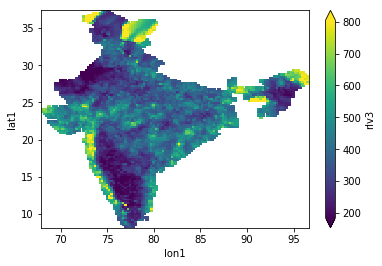

In [7]:
ds3= df3.set_index(['lat1','lon1']).to_xarray()
print(ds3)
ds3['rlv3'].plot(robust=True)
plt.show()

In [9]:
ds3.to_netcdf(r"C:\Users\Pranjali\Downloads\ds3p.nc")